In [54]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import gc
import os

In [16]:
train_raw = pd.read_csv('./train.csv')
test_raw = pd.read_csv('./test.csv')

In [17]:
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


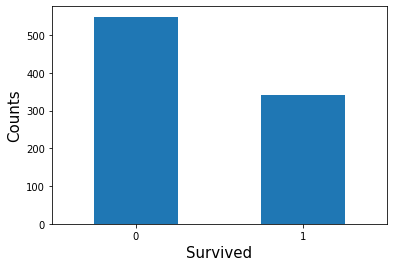

In [18]:
#sns.countplot(train_raw['Survived'])
ax = train_raw['Survived'].value_counts().plot(kind='bar',
                                         rot=0)
ax.set_xlabel('Survived', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
plt.show()

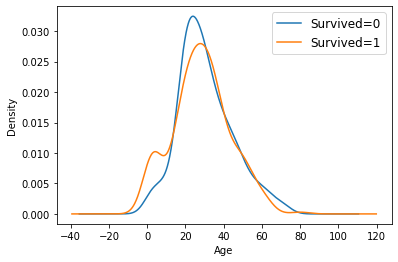

In [19]:
ax = train_raw.loc[train_raw.Survived==0, 'Age'].plot(kind='density')
ax = train_raw.loc[train_raw.Survived==1, 'Age'].plot(kind='density')
ax.legend(['Survived=0', 'Survived=1'], fontsize=12)
ax.set_xlabel('Age')
ax.set_ylabel('Density')
plt.show()

In [20]:
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

X_train = preprocessing(train_raw)
y_train = train_raw['Survived'].values
X_test = preprocessing(test_raw)

In [21]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)

In [22]:
X_train.shape

(891, 15)

In [23]:
Normarizascaler = StandardScaler()
Normarizascaler.fit(X_train)

StandardScaler()

In [24]:
X_train = Normarizascaler.transform(X_train)
X_test = Normarizascaler.transform(X_test)

In [25]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()

X_test = torch.from_numpy(X_test).float()

In [26]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, 20)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(20, 10)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(10, 2)
        
        self.layers = [self.l1, self.a1, self.l2, self.a2, self.l3]
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [33]:
def train(train_dataloader, model, optimizer):
    total_loss = 0
    for data in train_dataloader:
        features, targets = data                  
        outputs = model(features)
        loss = loss_fn(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return model, total_loss

In [28]:
def val(val_dataloader, model):
    with torch.no_grad():
        total_accuracy = 0
        total_loss = 0
        for data in val_dataloader:
            features, targets = data
            outputs = model(features)
            loss = loss_fn(outputs, targets)
            y_val_preds = outputs.argmax(1)
            accuracy = (y_val_preds == targets).sum()
            total_accuracy += accuracy.item()
            total_loss += loss.item()
        total_accuracy = total_accuracy / len(val_dataloader.dataset)
        return total_accuracy, total_loss


In [ ]:
# 开始训练 5折交叉验证，把五次模型的预测结果进行平均加权
k = 5
n_epochs = 100

cv_aucs = []
full_val_preds = np.zeros(X_train.shape[0])
y_preds = np.zeros(X_test.shape[0])

kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=3)

for fold_num, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
    print(f"=============Fold {fold_num}==============")
    # data  
    X_train_f, X_val_f = X_train[train_index], X_train[val_index]
    y_train_f, y_val_f = y_train[train_index], y_train[val_index]
    
    train_dataset = TensorDataset(X_train_f, y_train_f)
    val_dataset = TensorDataset(X_val_f, y_val_f)
    
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    
    # 需要在每次fold时都重新定义一遍，要不然会在上一次model训练的结果上，继续训练
    model = Model(X_train.shape[1])
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    
#     result = []
    bestscore = 0
    for i in range(n_epochs):
        model, train_loss = train(train_dataloader, model, optimizer)
        val_accuracy, val_loss = val(val_dataloader, model)
#         result.append([i, train_loss, val_loss, val_accuracy])
#         if i % 10 == 0:
        print("\n epoch %d, train loss: %.2f, val loss: %.2f, val accuracy: %.2f" 
              % (i, train_loss, val_loss, val_accuracy))
        if bestscore < val_accuracy:
            bestscore = val_accuracy
            state = {
                     'state_dict': model.state_dict(),
                     'optimizer_dict': optimizer.state_dict(),
                     'bestscore': bestscore
            } 
    torch.save(state, f"models/model{fold_num}.pth")

In [43]:
y_test = torch.zeros(X_test.shape[0])
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [50]:
for a in test_dataloader:
    print(a[1].shape)
    break

torch.Size([64])


In [88]:
def inference(model, state_lists, test_dataloader):
    allpreds = 0
    model.eval()
    with torch.no_grad():
        # load the trained model
        for state in state_lists:
            print(f"State: {state}")
            state_dict = torch.load(state)
            model.load_state_dict(state_dict["state_dict"])
            
            # predict
            preds = []
            for a in test_dataloader:
                # get X_test from test_dataloader
                output = model(a[0])
                preds.append(output.squeeze(-1).detach().cpu().numpy())
            
            allpreds += np.concatenate(preds)
    
        return allpreds / 5            

In [89]:
state_lists = [os.path.join("models", x) for x in os.listdir("models") if x.endswith(".pth")]
predict_results = inference(model, state_lists, test_dataloader)

State: models/model0.pth
State: models/model1.pth
State: models/model3.pth
State: models/model2.pth
State: models/model4.pth


In [99]:
pred = [s.argmax() for s in predict_results]
df = {'PassengerId': test_raw.PassengerId, 'Transported': pred}
df_preds = pd.DataFrame(df).set_index(['PassengerId'])
df_preds.to_csv('pytorch_predction.csv')